## Real-bogus classification for the Zwicky Transient Facility (ZTF) using deep learning

Efficient automated detection of flux-transient, reoccurring flux-variable, and moving objects 
is increasingly important for large-scale astronomical surveys.

The [Zwicky Transient Facilty (ZTF)](https://ztf.caltech.edu) is a new robotic time-domain survey currently in operation at the Palomar Observatory in California, USA. ZTF is capable of visiting the entire visible sky north of $-30$&deg; declination every night. ZTF observes the sky in the `g`, `r`, and `i` bands at different cadences depending on the scientific program and sky region. The new 576 megapixel camera with a 47 deg<sup>2</sup> field of view, installed on the Samuel Oschin 48-inch (1.2-m) Schmidt Telescope, can scan more than 3750 deg<sup>2</sup> per hour, to a $5\sigma$ detection limit of 20.7 mag in the $r$ band with a 30-second exposure during new moon.

Events observed by ZTF may have been triggered from a flux-transient, a reoccurring flux-variable, or a moving object. The metadata and contextual information including the cutouts are put into "alert packets" that are distributed via the ZTF Alert Distribution System (ZADS). On a typical night, the number of detected events ranges from $10^5 - 10^6$.

<table><tr><td><img src='img/fig-ztf.png'></td><td><img src='img/fig-ztf_alerts.png'></td></tr></table>

The real/bogus ($rb$) machine learning (ML) classifiers are designed to separate genuine astrophysical events from bogus detections by scoring individual sources on a scale from 0.0 (bogus) to 1.0 (real). Currently, ZTF employs two $rb$ classifiers: a feature-based random forest classifier ($rfrb$), and `braai` a convolutional-neural-network, deep-learning classifier.

In this tutorial, we will build a deep $rb$ classifier based on `braai`. We will use a data set consisting of $11.5k$ labeled alerts from the [ZTF public alert stream](https://ztf.uw.edu/alerts/public/).

For further details on `braai` please refer to Duev+ 2019 (in prep., will be submitted to MNRAS this week).

### Imports

In [1]:
from IPython.display import HTML, display
import tqdm
import json
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.model_selection import train_test_split
import datetime
from astropy.time import Time

import os
import io
import gzip
from astropy.io import fits
from bson.json_util import loads, dumps

import matplotlib.pyplot as plt
# plt.style.use(['dark_background'])
from pandas.plotting import register_matplotlib_converters, scatter_matrix
register_matplotlib_converters()
%matplotlib inline

### Data set

Download from `skipper` if necessary:

In [2]:
#!wget -O candidates.csv https://skipper.caltech.edu:5001/s/sCTdtkCxz5Nsy8a/download
#!wget -O triplets.norm.npy https://skipper.caltech.edu:5001/s/jmbkK7PFnK86fTp/download
#!ls

#### Candidates

First load the $csv$ file containing the `candidate` block of the alerts (cutouts and previous detections are excluded). All alerts are labeled (0=bogus, 1=real).

In [3]:
df = pd.read_csv('candidates.csv')
display(df)
df.info()
df.describe()

,Unnamed: 0,aimage,aimagerat,bimage,bimagerat,candid,chinr,chipsf,classtar,clrcoeff,...,szmag1,szmag2,szmag3,tblid,tooflag,xpos,ypos,zpclrcov,zpmed,label
0,0,1.051,0.308211,0.991,0.290616,737414800515015021,3.024,1.074084,0.953,0.090182,...,19.752300,18.349100,19.709101,21,0,1102.627808,2502.003174,-0.000003,26.278999,1
1,1,0.911,0.283801,0.877,0.273209,548211733715015007,0.895,1.868645,0.921,NaN,...,18.470301,20.777000,20.725700,7,0,2904.806396,280.736298,NaN,NaN,1
2,2,0.802,0.586078,0.669,0.488886,527282584015015018,2.373,1.259607,0.876,NaN,...,17.358500,-999.000000,-999.000000,18,0,1045.247070,2085.618652,NaN,NaN,1
3,3,0.708,0.534324,0.673,0.507909,540383446315015002,0.217,5.922930,0.992,NaN,...,14.093500,19.026699,20.882000,2,0,279.002289,381.362091,NaN,NaN,1
4,4,0.927,0.317466,0.881,0.301712,806286202415015004,3.389,3.200528,0.983,-0.080435,...,20.331200,20.488501,-999.000000,4,0,1296.672852,861.606018,-0.000052,26.166000,1
5,5,0.736,0.281992,0.712,0.272797,669136891615015022,7.770,4.304990,0.984,0.078656,...,20.375401,-999.000000,16.879499,22,0,2776.215820,1663.289185,-0.000003,26.191999,1
6,6,0.847,0.298239,0.742,0.261268,540292995315015018,1.325,0.999686,0.978,NaN,...,15.185000,19.643900,19.476601,18,0,1236.580688,2640.000977,NaN,NaN,1
7,7,0.587,0.327933,0.527,0.294413,675144872815015062,7.422,1.742821,0.974,0.095612,...,18.376801,-999.000000,-999.000000,62,0,564.192993,1361.725952,-0.000002,26.330999,1
8,8,0.663,0.453448,0.605,0.413780,671461315015015045,3.011,2.007285,0.915,0.101529,...,16.375799,18.535400,-999.000000,45,0,397.519012,960.680725,-0.000009,26.287001,1
9,9,0.705,0.282000,0.649,0.259600,713456381615015039,1.809,1.126633,0.876,-0.046420,...,18.462299,19.901100,18.954800,39,0,1343.400757,2941.009033,-0.000149,23.504000,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11556 entries, 0 to 11555
Columns: 103 entries, Unnamed: 0 to label
dtypes: float64(79), int64(19), object(5)
memory usage: 9.1+ MB


,Unnamed: 0,aimage,aimagerat,bimage,bimagerat,candid,chinr,chipsf,classtar,clrcoeff,...,szmag1,szmag2,szmag3,tblid,tooflag,xpos,ypos,zpclrcov,zpmed,label
count,11556.00000,11556.000000,11556.000000,11556.000000,11556.000000,1.155600e+04,11556.000000,11556.000000,11556.000000,8448.000000,...,11556.000000,11556.000000,11556.000000,11556.000000,11556.0,11556.000000,11556.000000,8448.000000,8448.000000,11556.000000
mean,5777.50000,1.073267,-8.026193,0.895498,-8.076731,6.393815e+17,-22.500750,17.101113,0.860534,0.027765,...,-141.066174,-237.406817,-260.553024,24.679387,0.0,1562.592689,1563.468948,-0.000087,26.162647,0.691589
std,3336.07419,0.888390,91.182468,0.676887,91.176462,1.074571e+17,156.702592,95.183081,0.232018,0.088743,...,368.660709,441.456463,454.140601,45.581802,0.0,891.664377,872.083664,0.002138,0.280054,0.461857
min,0.00000,0.289000,-999.000000,0.254000,-999.000000,4.444618e+17,-999.000000,0.145480,0.000000,-0.791248,...,-999.000000,-999.000000,-999.000000,0.000000,0.0,11.030300,10.019900,-0.127653,21.896999,0.000000
25%,2888.75000,0.731000,0.268761,0.654000,0.232750,5.404585e+17,0.733000,1.450537,0.841000,-0.051204,...,12.753225,-999.000000,-999.000000,4.000000,0.0,787.948593,809.693359,-0.000017,26.132000,0.000000
50%,5777.50000,0.838000,0.320363,0.752000,0.287891,6.714277e+17,1.416000,2.603290,0.974000,0.073595,...,17.182651,18.185300,18.388551,11.000000,0.0,1562.246704,1591.725708,-0.000008,26.218000,1.000000
75%,8666.25000,1.075000,0.380548,0.923000,0.337443,7.182429e+17,3.944000,7.096814,0.983000,0.097531,...,19.207199,20.155224,20.324699,25.000000,0.0,2331.450623,2338.382385,-0.000004,26.280001,1.000000
max,11555.00000,23.407000,55.650002,15.154000,47.450001,8.652526e+17,121.080002,7037.184570,1.000000,2.095540,...,22.355900,23.205200,22.111300,871.000000,0.0,3062.439697,3070.481934,-0.000001,26.827999,1.000000


In [ ]:
print(f'num_bogus: {np.sum(df.label == 0)}')
print(f'num_real: {np.sum(df.label == 1)}')

#### Cutout images

In [4]:
def make_triplet(alert, normalize: bool = False, to_tpu: bool = False):
    """
        Feed in alert packet
    """
    cutout_dict = dict()

    for cutout in ('science', 'template', 'difference'):
        cutout_data = loads(dumps([alert[f'cutout{cutout.capitalize()}']['stampData']]))[0]

        # unzip
        with gzip.open(io.BytesIO(cutout_data), 'rb') as f:
            with fits.open(io.BytesIO(f.read())) as hdu:
                data = hdu[0].data
                # replace nans with zeros
                cutout_dict[cutout] = np.nan_to_num(data)
                # normalize
                if normalize:
                    cutout_dict[cutout] /= np.linalg.norm(cutout_dict[cutout])

        # pad to 63x63 if smaller
        shape = cutout_dict[cutout].shape
        if shape != (63, 63):
            # print(f'Shape of {candid}/{cutout}: {shape}, padding to (63, 63)')
            cutout_dict[cutout] = np.pad(cutout_dict[cutout], [(0, 63 - shape[0]), (0, 63 - shape[1])],
                                         mode='constant', constant_values=1e-9)

    triplet = np.zeros((63, 63, 3))
    triplet[:, :, 0] = cutout_dict['science']
    triplet[:, :, 1] = cutout_dict['template']
    triplet[:, :, 2] = cutout_dict['difference']
    
    if to_tpu:
        # Edge TPUs require additional processing
        triplet = np.rint(triplet * 128 + 128).astype(np.uint8).flatten()
    
    return triplet

We will now load pre-processed image cutout triplets: [epochal science image, reference image, ZOGY difference image]. The ZTF cutout images are centered on the event candidate and are of size 63x63 pixels (or smaller, if the event is detected near the CCD edge) at a plate scale of 1$"$ per pixel. We perform independent $L^2$-normalization of the epochal science, reference, and difference cutouts and stack them to form 63x63x3 triplets that are input into the model. Smaller examples are accordingly padded using a constant pixel value of $10^{-9}$. See function `make_triplet` above.

In [5]:
# We will use memory mapping as the file is relatively large (1 GB)
triplets = np.load('triplets.norm.npy', mmap_mode='r')

#### Visuals

Plot a few triplet examples:

candid: 478450340515015062, label: 0


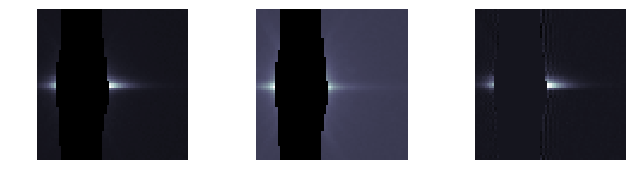

candid: 689533410315015009, label: 1


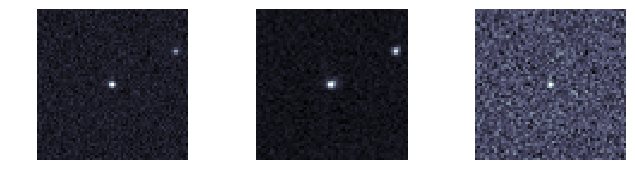

candid: 508420080215015017, label: 0


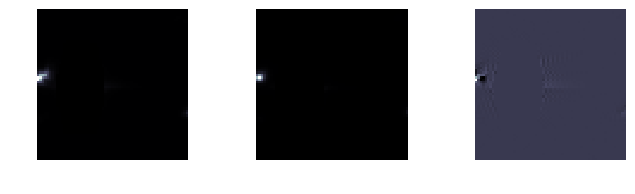

candid: 672223143915015008, label: 1


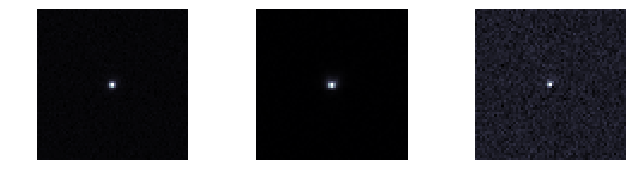

candid: 710520431515015000, label: 1


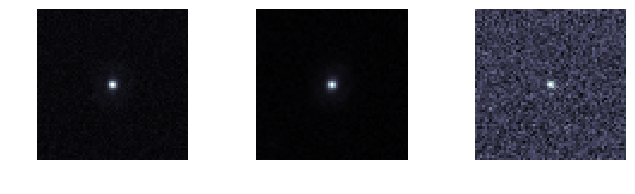

In [6]:
ind = np.random.randint(0, high=len(df), size=5)
for ii in ind:
    print(f'candid: {df.loc[ii, "candid"]}, label: {df.loc[ii, "label"]}')
    fig = plt.figure(figsize=(8, 2), dpi=100)
    triplet = triplets[ii, :]
    ax = fig.add_subplot(131)
    ax.axis('off')
    ax.imshow(triplet[:, :, 0], origin='lower', cmap=plt.cm.bone)
    ax2 = fig.add_subplot(132)
    ax2.axis('off')
    ax2.imshow(triplet[:, :, 1], origin='lower', cmap=plt.cm.bone)
    ax3 = fig.add_subplot(133)
    ax3.axis('off')
    ax3.imshow(triplet[:, :, 2], origin='lower', cmap=plt.cm.bone)
    plt.show()

Let's explore the dataset a little bit:

/Users/dmitryduev/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3296: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


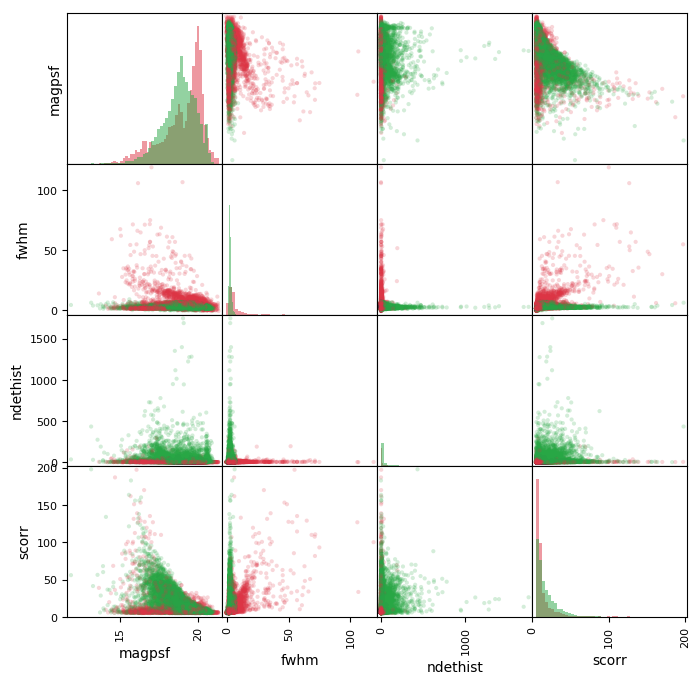

In [7]:
fig = plt.figure(figsize=(8, 8), dpi=100)
ax = fig.add_subplot(111)

color_wheel = {0: "#dc3545", 
               1: "#28a745"}
colors = df["label"].map(lambda x: color_wheel.get(x))

columns = ['magpsf', 'fwhm', 'ndethist', 'scorr']

axx = scatter_matrix(df.loc[df.label >= 0, columns], 
                     alpha=0.2,  diagonal='hist', ax=ax, grid=True, color=colors,
                     hist_kwds={'color': 'darkblue', 'alpha': 0, 'bins': 50})

for rc in range(len(columns)):
    rc_y_max = 0
    for group in color_wheel.keys():
        y = df[df.label == group][columns[rc]]
        hh = axx[rc][rc].hist(y, bins=50, alpha=0.5, color=color_wheel[group], density=1)
#         print(np.min(hh[0]), np.max(hh[0]))
        rc_y_max = max(rc_y_max, np.max(hh[0]))
        axx[rc][rc].set_ylim([0, 1.1*rc_y_max])

# scatter_matrix(df.loc[df.label == 0, ['magpsf', 'fwhm', 'ndethist']], 
#                alpha=0.2,  diagonal='hist', ax=ax,
#                hist_kwds={'color': '#dc3545', 'alpha': 0.5, 'bins': 100}, color='#dc3545')
# scatter_matrix(df.loc[df.label == 1, ['magpsf', 'fwhm', 'ndethist']], 
#                alpha=0.2,  diagonal='hist', ax=ax,
#                hist_kwds={'color': '#28a745', 'alpha': 0.5, 'bins': 100}, color='#28a745')

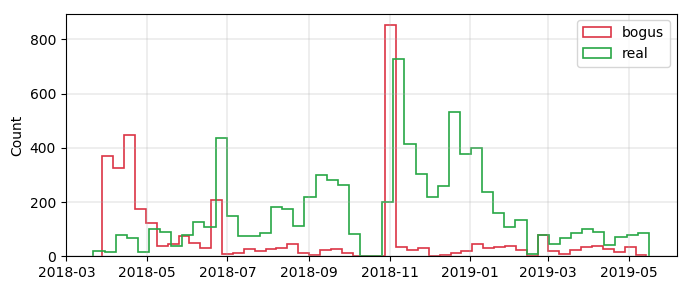

In [8]:
df['date'] = df['jd'].map(lambda x: Time(x, format='jd').datetime)
fig = plt.figure(figsize=(7, 3), dpi=100)
ax = fig.add_subplot(111)
ax.hist(df.loc[df['label'] == 0, 'date'], bins=50, #linestyle='dashed',
        color=color_wheel[0], histtype='step', label='bogus', linewidth=1.2)
ax.hist(df.loc[df['label'] == 1, 'date'], bins=50,
        color=color_wheel[1], histtype='step', label='real', linewidth=1.2)
# ax.set_xlabel('Date')
ax.set_ylabel('Count')
ax.legend(loc='best')
ax.grid(True, linewidth=.3)
plt.tight_layout()

We will use 81\% / 9\% / 10\% training/validation/test data split:

In [9]:
test_split = 0.1

# set random seed for reproducable results:
random_state = 42

x_train, x_test, y_train, y_test = train_test_split(triplets, df.label, 
                                                    test_size=test_split, random_state=random_state)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(10400, 63, 63, 3) (1156, 63, 63, 3) (10400,) (1156,)


### Deep Learning in one slide

<img src='img/fig-dl.png'>

### `braai` architecture

We will use a simple custom VGG-like sequential model ($VGG6$; this architecture was first proposed by the Visual Geometry Group of the Department of Engineering Science, University of Oxford, UK). The model has six layers with trainable parameters: four convolutional and two fully-connected. The first two convolutional layers use 16 3x3 pixel filters each while in the second pair, 32 3x3 pixel filters are used. To prevent over-fitting, a dropout rate of 0.25 is applied after each max-pooling layer and a dropout rate of 0.5 is applied after the second fully-connected layer. ReLU activation functions (Rectified Linear Unit --  a function defined as the positive part of its argument) are used for all five hidden trainable layers; a sigmoid activation function is used for the output layer.

![](img/fig-braai2.png)

In [10]:
def vgg6(input_shape=(63, 63, 3), n_classes: int = 1):
    """
        VGG6
    :param input_shape:
    :param n_classes:
    :return:
    """

    model = tf.keras.models.Sequential(name='VGG6')
    # input: 63x63 images with 3 channel -> (63, 63, 3) tensors.
    # this applies 16 convolution filters of size 3x3 each.
    model.add(tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=input_shape, name='conv1'))
    model.add(tf.keras.layers.Conv2D(16, (3, 3), activation='relu', name='conv2'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.25))

    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', name='conv3'))
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', name='conv4'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(4, 4)))
    model.add(tf.keras.layers.Dropout(0.25))

    model.add(tf.keras.layers.Flatten())

    model.add(tf.keras.layers.Dense(256, activation='relu', name='fc_1'))
    model.add(tf.keras.layers.Dropout(0.5))
    # output layer
    activation = 'sigmoid' if n_classes == 1 else 'softmax'
    model.add(tf.keras.layers.Dense(n_classes, activation=activation, name='fc_out'))

    return model

### Model training

`braai` is implemented using `TensorFlow` software and its high-level `Keras` API. We will use the binary cross-entropy loss function, the Adam optimizer, a batch size of 64, and a 81\%/9\%/10\% training/validation/test data split. The training image data are weighted per class to mitigate the real vs. bogus imbalance in the data sets. To augment the data, the images may be flipped horizontally and/or vertically at random. No random rotations and translations will be added.

In [11]:
def save_report(path: str = './', stamp: str = None, report: dict = dict()):
    f_name = os.path.join(path, f'report.{stamp}.json')
    with open(f_name, 'w') as f:
        json.dump(report, f, indent=2)

# make train and test masks:
_, _, mask_train, mask_test = train_test_split(df.label, list(range(len(df.label))),
                                                   test_size=test_split, random_state=random_state)
masks = {'training': mask_train, 'test': mask_test}

In [12]:
tf.keras.backend.clear_session()

loss = 'binary_crossentropy'
optimizer = 'adam'
epochs = 100
patience = 50
# epochs = 10
# patience = 5
validation_split = 0.1
class_weight = True
batch_size = 64

# halt training if no gain in validation accuracy over patience epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience)

data_augmentation = {'horizontal_flip': True,
                     'vertical_flip': True,
                     'rotation_range': 0,
                     'fill_mode': 'constant',
                     'cval': 1e-9}
datagen = tf.keras.preprocessing.image.ImageDataGenerator(horizontal_flip=data_augmentation['horizontal_flip'],
                                                          vertical_flip=data_augmentation['vertical_flip'],
                                                          rotation_range=data_augmentation['rotation_range'],
                                                          fill_mode=data_augmentation['fill_mode'],
                                                          cval=data_augmentation['cval'],
                                                          validation_split=validation_split)

training_generator = datagen.flow(x_train, y_train, batch_size=batch_size, subset='training')
validation_generator = datagen.flow(x_train, y_train, batch_size=batch_size, subset='validation')

In [13]:
binary_classification = True if loss == 'binary_crossentropy' else False
n_classes = 1 if binary_classification else 2

# training data weights
if class_weight:
    # weight data class depending on number of examples?
    if not binary_classification:
        num_training_examples_per_class = np.sum(y_train, axis=0)
    else:
        num_training_examples_per_class = np.array([len(y_train) - np.sum(y_train), np.sum(y_train)])

    assert 0 not in num_training_examples_per_class, 'found class without any examples!'

    # fewer examples -- larger weight
    weights = (1 / num_training_examples_per_class) / np.linalg.norm((1 / num_training_examples_per_class))
    normalized_weight = weights / np.max(weights)

    class_weight = {i: w for i, w in enumerate(normalized_weight)}

else:
    class_weight = {i: 1 for i in range(2)}
    
# image shape:
image_shape = x_train.shape[1:]
print('Input image shape:', image_shape)

Input image shape: (63, 63, 3)


Build and compile the model:

In [ ]:
model = vgg6(input_shape=image_shape, n_classes=n_classes)

# set up optimizer:
if optimizer == 'adam':
    optimzr = tf.keras.optimizers.Adam(lr=3e-4, beta_1=0.9, beta_2=0.999,
                                       epsilon=None, decay=0.0, amsgrad=False)
elif optimizer == 'sgd':
    optimzr = tf.keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=1e-6, nesterov=True)
else:
    print('Could not recognize optimizer, using Adam')
    optimzr = tf.keras.optimizers.Adam(lr=3e-4, beta_1=0.9, beta_2=0.999,
                                       epsilon=None, decay=0.0, amsgrad=False)

model.compile(optimizer=optimzr, loss=loss, metrics=['accuracy'])

print(model.summary())

Model: "VGG6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 61, 61, 16)        448       
_________________________________________________________________
conv2 (Conv2D)               (None, 59, 59, 16)        2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 29, 29, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 29, 29, 16)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 27, 27, 32)        4640      
_________________________________________________________________
conv4 (Conv2D)               (None, 25, 25, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 32)          0      

Train!

In [ ]:
run_t_stamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
model_name = f'braai_{model.name}_{run_t_stamp}'

h = model.fit_generator(training_generator,
                        steps_per_epoch=len(x_train) // batch_size,
                        validation_data=validation_generator,
                        validation_steps=(len(x_train)*validation_split) // batch_size,
                        class_weight=class_weight,
                        epochs=epochs,
                        verbose=1, callbacks=[early_stopping])

Epoch 1/100
162/162 [==============================] - 44s 274ms/step - loss: 6.3612 - accuracy: 0.6444 - val_loss: 1.0611 - val_accuracy: 0.8369
Epoch 2/100
162/162 [==============================] - 44s 271ms/step - loss: 1.4098 - accuracy: 0.7580 - val_loss: 0.8108 - val_accuracy: 0.8535
Epoch 3/100
162/162 [==============================] - 45s 276ms/step - loss: 0.7971 - accuracy: 0.7920 - val_loss: 0.5841 - val_accuracy: 0.8691
Epoch 4/100
162/162 [==============================] - 42s 258ms/step - loss: 0.5501 - accuracy: 0.8321 - val_loss: 0.4828 - val_accuracy: 0.8916
Epoch 5/100
162/162 [==============================] - 45s 276ms/step - loss: 0.4318 - accuracy: 0.8510 - val_loss: 0.4076 - val_accuracy: 0.9043
Epoch 6/100
162/162 [==============================] - 44s 269ms/step - loss: 0.3533 - accuracy: 0.8656 - val_loss: 0.3748 - val_accuracy: 0.9053
Epoch 7/100
162/162 [==============================] - 47s 289ms/step - loss: 0.3240 - accuracy: 0.8749 - val_loss: 0.3404 -

### Model evaluation

Let's now evaluate the resulting model:

In [ ]:
print('Evaluating on training set to check misclassified samples:')
labels_training_pred = model.predict(x_train, batch_size=batch_size, verbose=1)
# XOR will show misclassified samples
misclassified_train_mask = np.array(list(map(int, df.label[masks['training']]))).flatten() ^ \
                           np.array(list(map(int, np.rint(labels_training_pred)))).flatten()
misclassified_train_mask = [ii for ii, mi in enumerate(misclassified_train_mask) if mi == 1]

misclassifications_train = {int(c): [int(l), float(p)]
                            for c, l, p in zip(df.candid.values[masks['training']][misclassified_train_mask],
                                               df.label.values[masks['training']][misclassified_train_mask],
                                               labels_training_pred[misclassified_train_mask])}
# print(misclassifications_train)

print('Evaluating on test set for loss and accuracy:')
preds = model.evaluate(x_test, y_test, batch_size=batch_size, verbose=1)
test_loss = float(preds[0])
test_accuracy = float(preds[1])
print("Loss = " + str(test_loss))
print("Test Accuracy = " + str(test_accuracy))

print('Evaluating on training set to check misclassified samples:')
preds = model.predict(x=x_test, batch_size=batch_size, verbose=1)

# XOR will show misclassified samples
misclassified_test_mask = np.array(list(map(int, df.label[masks['test']]))).flatten() ^ \
                          np.array(list(map(int, np.rint(preds)))).flatten()
misclassified_test_mask = [ii for ii, mi in enumerate(misclassified_test_mask) if mi == 1]

misclassifications_test = {int(c): [int(l), float(p)]
                           for c, l, p in zip(df.candid.values[masks['test']][misclassified_test_mask],
                                              df.label.values[masks['test']][misclassified_test_mask],
                                              preds[misclassified_test_mask])}

# round probs to nearest int (0 or 1)
labels_pred = np.rint(preds)

#### Training vs. validation accuracy

In [ ]:
if 'accuracy' in h.history:
    train_acc = h.history['accuracy']
    val_acc = h.history['val_accuracy']
else:
    train_acc = h.history['acc']
    val_acc = h.history['val_acc']

train_loss = h.history['loss']
val_loss = h.history['val_loss']

fig = plt.figure(figsize=(7, 3), dpi=100)
ax = fig.add_subplot(121)
ax.plot(train_acc, label='Training', linewidth=1.2)
ax.plot(val_acc, label='Validation', linewidth=1.2)
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend(loc='best')
ax.grid(True, linewidth=.3)

ax2 = fig.add_subplot(122)
ax2.plot(train_loss, label='Training', linewidth=1.2)
ax2.plot(val_loss, label='Validation', linewidth=1.2)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend(loc='best')
ax2.grid(True, linewidth=.3)
plt.tight_layout()

#### Confusion matrices with score threshold=0.5

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues,
                          colorbar=False,
                          savefig=False):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if title is not None:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
#     print(unique_labels(y_true, y_pred))
#     classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(dpi=70)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    if colorbar:
        ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
#     fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, f'{cm[i, j]:.1f}%' if normalize else f'{cm[i, j]:d}', #format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black",
                    size=20)
    fig.tight_layout()
    
    if savefig:
        plt.tight_layout()
        plt.savefig(savefig, dpi=300)
    
    return ax

In [ ]:
confusion_matr = confusion_matrix(y_test, labels_pred)
confusion_matr_normalized = confusion_matr.astype('float') / confusion_matr.sum(axis=1)[:, np.newaxis]

print('Confusion matrix:')
print(confusion_matr)

print('Normalized confusion matrix:')
print(confusion_matr_normalized)

# plot:
t_set = 'test'
plot_confusion_matrix(y_true=df.label.values[masks[t_set]], y_pred=labels_pred, 
                      classes=['bogus', 'real'],
                      normalize=False,
                      title=None,
                      cmap=plt.cm.Blues)
plot_confusion_matrix(y_true=df.label.values[masks[t_set]], y_pred=labels_pred, 
                      classes=['bogus', 'real'],
                      normalize=True,
                      title=None,
                      cmap=plt.cm.Blues)

#### FNR vs FPR

In [ ]:
rbbins = np.arange(-0.0001, 1.0001, 0.0001)
h_b, e_b = np.histogram(preds[(df.label[masks['test']] == 0).values], bins=rbbins, density=True)
h_b_c = np.cumsum(h_b)
h_r, e_r = np.histogram(preds[(df.label[masks['test']] == 1).values], bins=rbbins, density=True)
h_r_c = np.cumsum(h_r)

# h_b, e_b

fig = plt.figure(figsize=(7, 4), dpi=100)
ax = fig.add_subplot(111)

rb_thres = np.array(list(range(len(h_b)))) / len(h_b)

ax.plot(rb_thres, h_r_c/np.max(h_r_c), 
        label='False Negative Rate (FNR)', linewidth=1.5)
ax.plot(rb_thres, 1 - h_b_c/np.max(h_b_c), 
        label='False Positive Rate (FPR)', linewidth=1.5)

mmce = (h_r_c/np.max(h_r_c) + 1 - h_b_c/np.max(h_b_c))/2
ax.plot(rb_thres, mmce, '--',
        label='Mean misclassification error', color='gray', linewidth=1.5)

ax.set_xlim([-0.05, 1.05])

ax.set_xticks(np.arange(0, 1.1, 0.1))
ax.set_yticks(np.arange(0, 1.1, 0.1))

# vals = ax.get_yticks()
# ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])

ax.set_yscale('log')
ax.set_ylim([5e-4, 1])
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.1%}'.format(x) if x < 0.01 else '{:,.0%}'.format(x) for x in vals])

# thresholds:
thrs = [0.5, ]
# thrs = [0.5, 0.74]
for t in thrs:
    m_t = rb_thres < t
    fnr = np.array(h_r_c/np.max(h_r_c))[m_t][-1]
    fpr = np.array(1 - h_b_c/np.max(h_b_c))[m_t][-1]
    print(t, fnr*100, fpr*100)
    # ax.vlines(t_1, 0, 1.1)
    ax.vlines(t, 0, max(fnr, fpr))
    ax.text(t - .05, max(fnr, fpr) + 0.01, f' {fnr*100:.1f}% FNR\n {fpr*100:.1f}% FPR', fontsize=10)

ax.set_xlabel('RB score threshold')
ax.set_ylabel('Cumulative percentage')
ax.legend(loc='lower center')
ax.grid(True, which='major', linewidth=.5)
ax.grid(True, which='minor', linewidth=.3)
plt.tight_layout()

#### ROC curve

In [ ]:
fig = plt.figure(figsize=(14, 5), dpi=100)
fig.subplots_adjust(bottom=0.09, left=0.05, right=0.70, top=0.98, wspace=0.2, hspace=0.2)
lw = 1.6
# ROCs
ax = fig.add_subplot(1, 2, 1)
# zoomed ROCs
ax2 = fig.add_subplot(1, 2, 2)

ax.plot([0, 1], [0, 1], color='#333333', lw=lw, linestyle='--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate (Contamination)')
ax.set_ylabel('True Positive Rate (Sensitivity)')
# ax.legend(loc="lower right")
# ax.legend(loc="best")
ax.grid(True, linewidth=.3)

# ax2.set_xlim([0.0, .2])
# ax2.set_ylim([0.8, 1.0])
ax2.set_xlim([0.0, .2])
ax2.set_ylim([0.8, 1.005])
ax2.set_xlabel('False Positive Rate (Contamination)')
ax2.set_ylabel('True Positive Rate (Sensitivity)')
# ax.legend(loc="lower right")
ax2.grid(True, linewidth=.3)

fpr, tpr, thresholds = roc_curve(df['label'][masks['test']], preds)
roc_auc = auc(fpr, tpr)

ax.plot(fpr, tpr, lw=lw)
ax2.plot(fpr, tpr, lw=lw, label=f'ROC (area = {roc_auc:.5f})')
ax2.legend(loc="lower right")

#### Generate report

In [ ]:
# generate training report in json format
print('Generating report...')
r = {'Run time stamp': run_t_stamp,
     'Model name': model_name,
     'Model trained': 'vgg6',
     'Batch size': batch_size,
     'Optimizer': optimizer,
     'Requested number of train epochs': epochs,
     'Early stopping after epochs': patience,
     'Training+validation/test split': test_split,
     'Training/validation split': validation_split,
     'Weight training data by class': class_weight,
     'Random state': random_state,
     'Number of training examples': x_train.shape[0],
     'Number of test examples': x_test.shape[0],
     'X_train shape': x_train.shape,
     'Y_train shape': y_train.shape,
     'X_test shape': x_test.shape,
     'Y_test shape': y_test.shape,
     'Data augmentation': data_augmentation,
     'Test loss': test_loss,
     'Test accuracy': test_accuracy,
     'Confusion matrix': confusion_matr.tolist(),
     'Normalized confusion matrix': confusion_matr_normalized.tolist(),
     'Misclassified test candids': list(misclassifications_test.keys()),
     'Misclassified training candids': list(misclassifications_train.keys()),
     'Test misclassifications': misclassifications_test,
     'Training misclassifications': misclassifications_train,
     'Training history': h.history
     }
for k in r['Training history'].keys():
    r['Training history'][k] = np.array(r['Training history'][k]).tolist()

# print(r)

save_report(path='./', stamp=run_t_stamp, report=r)
print('Done.')

### Some real data

In [ ]:
def plot_triplet(tr):
    fig = plt.figure(figsize=(8, 2), dpi=100)
    ax = fig.add_subplot(131)
    ax.axis('off')
    ax.imshow(tr[:, :, 0], origin='upper', cmap=plt.cm.bone)
    ax2 = fig.add_subplot(132)
    ax2.axis('off')
    ax2.imshow(tr[:, :, 1], origin='upper', cmap=plt.cm.bone)
    ax3 = fig.add_subplot(133)
    ax3.axis('off')
    ax3.imshow(tr[:, :, 2], origin='upper', cmap=plt.cm.bone)
    plt.show()

In [ ]:
#!wget -O 714287740515015072.json https://raw.githubusercontent.com/dmitryduev/braai/master/nb/714287740515015072.json
#!wget -O 893215910715010007.json https://raw.githubusercontent.com/dmitryduev/braai/master/nb/893215910715010007.json

In [ ]:
with open('714287740515015072.json', 'r') as f:
    al = json.load(f)
print(al['candidate']['rb'])
tr = make_triplet(al)
plot_triplet(tr)
model.predict(np.expand_dims(tr, axis=0))

In [ ]:
with open('893215910715010007.json', 'r') as f:
    al = json.load(f)
print(al['candidate']['rb'])
tr = make_triplet(al)
plot_triplet(tr)
model.predict(np.expand_dims(tr, axis=0))